In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from keras.preprocessing import image as Kimage
from keras.utils import np_utils
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint  
from keras import optimizers
from skimage.transform import resize
from tqdm import tqdm
import pydicom
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
print(os.listdir("Data"))
import keras

['data.csv', 'images', '.ipynb_checkpoints']


In [2]:
model_type = 'FC1024'
dropout = 0.2
optimizer_type = 'Adam'
learning_rate = 1e-4
Augmentation_Indicator = False
epochs = 20
batch_size = 8
transfer_learning = True
random_state = 1607

In [3]:
# Load train labels
input_data = pd.read_csv("Data/data.csv")
input_data['img_path'] = 'Data/images/' + input_data['patientId'] + '.dcm'

In [4]:
input_data.head()

,Unnamed: 0,patientId,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,img_path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,Data/images/0004cfab-14fd-4e49-80ba-63a80b6bdd...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,Data/images/00313ee0-9eaa-42f4-b0ab-c148ed3241...
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,Data/images/00322d4d-1c29-4943-afc9-b6754be640...
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,Data/images/003d8fa0-6bf1-40ed-b54c-ac657f8495...
4,4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,Data/images/00436515-870c-4b36-a041-de91049b9a...


In [5]:
input_data = input_data.drop(['Unnamed: 0', 'Modality', 'BodyPartExamined', 'ViewPosition', 'ConversionType',
       'Rows', 'Columns', 'PixelSpacing'], axis = 1)

In [6]:
input_data.dtypes

patientId     object
Target         int64
class         object
PatientAge     int64
PatientSex    object
img_path      object
dtype: object

In [7]:
# Convert class into categorical variable
input_data['class'] = pd.Categorical(input_data['class'])
input_data['target'] = input_data['class'].cat.codes

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
input_data['class'] = label_encoder.fit_transform(input_data['class'])

In [9]:
input_data.head()

,patientId,Target,class,PatientAge,PatientSex,img_path,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,51,F,Data/images/0004cfab-14fd-4e49-80ba-63a80b6bdd...,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,1,48,F,Data/images/00313ee0-9eaa-42f4-b0ab-c148ed3241...,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,1,19,M,Data/images/00322d4d-1c29-4943-afc9-b6754be640...,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,2,28,M,Data/images/003d8fa0-6bf1-40ed-b54c-ac657f8495...,2
4,00436515-870c-4b36-a041-de91049b9ab4,1,0,32,F,Data/images/00436515-870c-4b36-a041-de91049b9a...,0


In [10]:
# remove, input_data  = train_test_split(input_data, 
#                                 test_size=0.03, 
#                                 random_state=random_state,
#                                 stratify=input_data['class'])

In [11]:
print('Total images taken: {}'.format(input_data.shape[0]))
input_data.head()

Total images taken: 26684


,patientId,Target,class,PatientAge,PatientSex,img_path,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,51,F,Data/images/0004cfab-14fd-4e49-80ba-63a80b6bdd...,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,1,48,F,Data/images/00313ee0-9eaa-42f4-b0ab-c148ed3241...,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,1,19,M,Data/images/00322d4d-1c29-4943-afc9-b6754be640...,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,2,28,M,Data/images/003d8fa0-6bf1-40ed-b54c-ac657f8495...,2
4,00436515-870c-4b36-a041-de91049b9ab4,1,0,32,F,Data/images/00436515-870c-4b36-a041-de91049b9a...,0


In [12]:
# Split train and test images
train, test = train_test_split(input_data, 
                                test_size=0.20, 
                                random_state=20,
                                stratify=input_data['class'])

# Split train and validation images
train, valid = train_test_split(train, 
                                test_size=0.20, 
                                random_state=20,
                                stratify=train['class'])

print('Total train images taken: {}'.format(train.shape[0]))
print('Total validation images taken: {}'.format(valid.shape[0]))
print('Total test images taken: {}'.format(test.shape[0]))

Total train images taken: 17077
Total validation images taken: 4270
Total test images taken: 5337


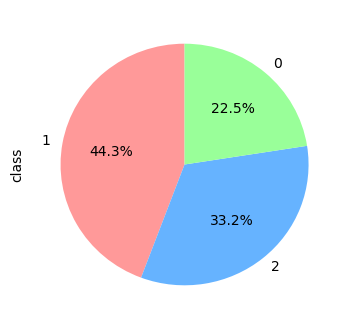

In [13]:
# Show the class balance in train images
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
train['class'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', 
                                   startangle=90, fontsize=10, colors = colors)
plt.show()

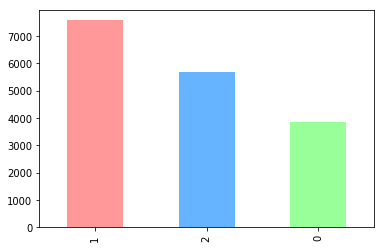

In [14]:
ax = plt.subplot(111)
train['class'].value_counts().plot(kind='bar', ax=ax, color=colors)
plt.show()

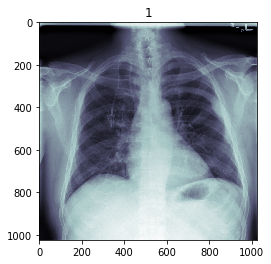

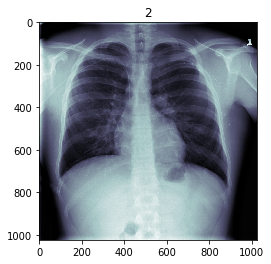

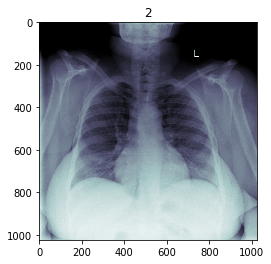

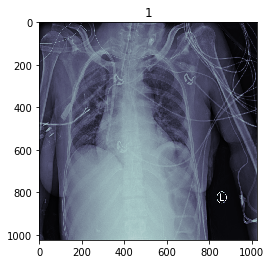

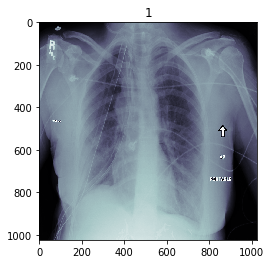

In [15]:
for i, row in enumerate(train.head().values):
    image_name = row[0]
    pneumonia_class = row[2]
    image_path = row[5]
    ds = pydicom.dcmread(image_path)
    plt.figure()
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(pneumonia_class)

In [16]:
IMG_SIZE = 255
img_dimension = [IMG_SIZE,IMG_SIZE]

In [17]:
def load_dicom_image(img_path):
    img_arr = pydicom.read_file(img_path).pixel_array
    img_arr = resize(img_arr, output_shape=img_dimension, mode='reflect')
    img_arr = img_arr/img_arr.max()
    slice_value = (255*img_arr).clip(0, 255).astype(np.uint8)
    img = Image.fromarray(slice_value)
    Kimage.pil_image = img
    return Kimage.pil_image

# Convert 3D tensors to 4D tensors where each 4D tensor is a different image
def path_to_tensor(img_path):
    # Read the dcm image using pydicom
    img = load_dicom_image(img_path)
    # convert PIL.Image.Image type to 3D tensor
    x = Kimage.img_to_array(img)
    # Since it is a grayscale image convert into three channels
    x = np.squeeze(np.repeat(x[:, :, np.newaxis], 3, axis=2), axis=3)
    # convert 3D tensor to 4D tensor with shape and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
# Load all the tensors and re-scale the data
train_tensors = paths_to_tensor(train['img_path'])
# valid_tensors = paths_to_tensor(valid['img_path'])
# test_tensors = paths_to_tensor(test['img_path'])

  0%|          | 0/17077 [00:00<?, ?it/s]/home/nbuser/.anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 17077/17077 [05:35<00:00, 50.96it/s]


In [19]:
valid_tensors = paths_to_tensor(valid['img_path'])
test_tensors = paths_to_tensor(test['img_path'])

  0%|          | 0/4270 [00:00<?, ?it/s]/home/nbuser/.anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 5337/5337 [01:40<00:00, 53.34it/s]


In [21]:
# Load all the targets
train_targets = np_utils.to_categorical(np.array(train['class']), 3)
valid_targets = np_utils.to_categorical(np.array(valid['class']), 3)
test_targets = np_utils.to_categorical(np.array(test['class']), 3)

In [22]:
test_tensors.shape

(5337, 255, 255, 3)

In [23]:
input_shape=(255, 255, 3)

In [24]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 32)      2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [25]:
# Compile the model
if optimizer_type == 'SGD':
    optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9)
elif optimizer_type == 'Adam':
    optimizer = optimizers.Adam(lr=learning_rate)
else:
    optimizer = optimizers.RMSprop()
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

In [30]:
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets), callbacks=callbacks,
          epochs=10, batch_size=batch_size, verbose=1)

Train on 17077 samples, validate on 4270 samples
Epoch 1/10
17077/17077 [==============================] - 415s 24ms/step - loss: 1.0359 - categorical_accuracy: 0.4573 - val_loss: 1.0053 - val_categorical_accuracy: 0.5035
Epoch 2/10
17077/17077 [==============================] - 415s 24ms/step - loss: 0.9645 - categorical_accuracy: 0.5009 - val_loss: 0.9680 - val_categorical_accuracy: 0.5164
Epoch 3/10
17077/17077 [==============================] - 415s 24ms/step - loss: 0.9349 - categorical_accuracy: 0.5250 - val_loss: 0.9444 - val_categorical_accuracy: 0.5370
Epoch 4/10
17077/17077 [==============================] - 415s 24ms/step - loss: 0.9176 - categorical_accuracy: 0.5352 - val_loss: 0.9641 - val_categorical_accuracy: 0.5049
Epoch 5/10
17077/17077 [==============================] - 414s 24ms/step - loss: 0.9036 - categorical_accuracy: 0.5471 - val_loss: 0.9692 - val_categorical_accuracy: 0.4871
Epoch 6/10
17077/17077 [==============================] - 414s 24ms/step - loss: 0.895

In [31]:
# get index of predicted value for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.2509%


In [32]:
input_shape

(255, 255, 3)